In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  10463      0 --:--:-- --:--:-- --:--:-- 10533
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 339.6MB 50kB/s 
+ set +ex
Installation succeeded!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import numpy as np
import cupy as cp
import csv


def read_data(path):
    datas = []
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in spamreader:
            tmp = row[0].split(',')
            floattmp = []
            for val in tmp:
                floattmp.append((float(val)))
            datas.append(floattmp)

    return datas

In [ ]:
def sigmoid(input):
    return 1/(1+cp.exp(-input))
def sigmoid_d(input):
    return sigmoid(input)*(1-sigmoid(input))
def loss(h, label, weights, lam):
    pre = cp.sum(cp.average(-label * cp.log(h) - (1-label)*cp.log(1-h), axis=0))
    n = 0
    theta_sum = 0
    for weight in weights:
        n += weight.size
        theta_sum += cp.sum(cp.square(weight))
    reg = lam/(2*n)*theta_sum
    return pre + reg
def accuracy(label, h):
    ht = label[np.abs(cp.asnumpy(h)-cp.asnumpy(label))<0.5]
    return len(ht)/len(label)

In [ ]:
import copy
class classifier:
    def __init__(self, shape, lam, learning_rate, start_weights=[]):
        if start_weights == []:
            self.weights = []
            for i in range(len(shape)-1):
                self.weights.append(cp.random.randn(shape[i]+1, shape[i+1]))
            self.start_weights = copy.deepcopy(self.weights)
        else:
            self.start_weights = copy.deepcopy(start_weights)
            self.weights = copy.deepcopy(start_weights)
        self.learning_rate = learning_rate
        self.lam = lam
        self.num_layer = len(self.weights)
        self.n = 0
        for weight in self.weights:
            self.n += weight.size
    
    def forward_pass(self, input, weights=[]):
        if weights==[]:
            weights = self.weights
        values = []
        values.append(cp.array(np.insert(cp.asnumpy(input), 0, 1, axis=1)))
        values.append(cp.dot(values[-1], weights[0]))
        values.append(cp.array(np.insert(cp.asnumpy(sigmoid(values[-1])),0,1,axis=1)))
        for i in range(1, len(weights)-1):
            values.append(cp.dot(values[-1], weights[i]))
            values.append(cp.array(np.insert(cp.asnumpy(sigmoid(values[-1])),0,1,axis=1)))
        values.append(cp.dot(values[-1], weights[-1]))
        values.append(sigmoid(values[-1]))
        
        return values

    def predict(self, input, best=True):
        if best:
            return (self.forward_pass(input,weights=self.best_weights)[-1])
        else:
            return (self.forward_pass(input,weights=self.weights)[-1])

    def gradient_descent(self, forward_values, label):
        update_values = []
        m = len(label)
        mult = (sigmoid_d(forward_values[-2]) * ((1-label)/(1-forward_values[-1]) - label/forward_values[-1])).T
        layer = len(self.weights)-1
        update_values.append(cp.dot(mult, forward_values[2*layer]).T)
        
        for i in range(1, len(self.weights)):
            layer = len(self.weights) - i - 1
            mult = (cp.dot(mult.T, self.weights[layer+1][1:,:].T) * (sigmoid_d(forward_values[layer*2+1]))).T
            update_values.append(cp.dot(mult, forward_values[2*layer]).T)
        for i in range(len(self.weights)):
            layer = len(self.weights)-i-1
            self.weights[layer] = self.weights[layer] - self.learning_rate * (update_values[i]/m + self.lam*self.weights[layer]/self.n)

    def optimize(self, data_train, label_train, data_test, label_test, epoch):
        forward_train = self.forward_pass(data_train)
        forward_test = self.forward_pass(data_test)
        h_train = forward_train[-1]
        h_test = forward_test[-1]
        y_pred_train = h_train
        y_pred_test =  h_test

        self.loss_train = [loss(h_train, label_train, self.weights, self.lam)]
        self.loss_test = [loss(h_test, label_test, self.weights, self.lam)]
        self.accuracy_train = [accuracy(label_train, h_train)*100]
        self.accuracy_test = [accuracy(label_test, h_test)*100]

        self.best_weights = []
        self.best_accuracy = 0
        
        i = 1
        stop_count = 0
        while True:

            self.gradient_descent(forward_train, label_train)
            forward_train = self.forward_pass(data_train)
            forward_test = self.forward_pass(data_test)
            h_train = forward_train[-1]
            h_test = forward_test[-1]

            self.loss_train.append(loss(h_train, label_train, self.weights, self.lam))
            self.loss_test.append(loss(h_test, label_test, self.weights, self.lam))
            self.accuracy_train.append(accuracy(label_train, h_train)*100)
            self.accuracy_test.append(accuracy(label_test, h_test)*100)
            if self.best_accuracy < self.accuracy_test[-1] and i>1000:
                self.best_accuracy = self.accuracy_test[-1]
                self.best_weights = self.weights
            i+= 1

            print(i," LOS_T:", format(float(self.loss_train[-1]),'.5f'), "\tACC_T:", format(float(self.accuracy_train[-1]),'.5f'), "| LOS_V:", format(float(self.loss_test[-1]),'.5f'), "ACC_V:" ,format(float(self.accuracy_test[-1]),'.5f'), format(self.lam/self.n,'.10f'), self.n)

            if self.loss_test[-1]>self.loss_test[-2]:
                stop_count += 1
            if stop_count == 3000:
                break

In [ ]:
datas = read_data('gdrive/My Drive/4-1/nlp/datas.csv')

datas = np.array(datas)

shuffle = np.arange(len(datas))
shuffle = np.random.shuffle(shuffle)
datas = datas[shuffle, : ]

datas = np.reshape(datas, (np.shape(datas)[1],np.shape(datas)[2]))

In [ ]:
Xp = []; Xn = []
Yp = []; Yn = []
Ypo = []; Yno = []

for data in datas:
    if data[-1] > 0 :
        Ypo.append(data[-1])
        Yp.append(1)
        Xp.append(list(data[:-1]))
    elif data[-1] < 0:
        Yno.append(data[-1])
        Yn.append(0)
        Xn.append(list(data[:-1]))
    
Xp = np.array(Xp)
Xn = np.array(Xn)
Yp = np.array(Yp)
Yn = np.array(Yn)
Ypo = np.array(Ypo)
Yno = np.array(Yno)

rate = 0.9
X_train = cp.array(np.append(Xp[:int(len(Xp)*rate),:], Xn[:int(len(Xn)*rate),:], axis=0))
X_test = cp.array(np.append(Xp[int(len(Xp)*rate):,:], Xn[int(len(Xn)*rate):,:], axis=0))

y_train = cp.array(np.append(Yp[:int(len(Yp)*rate)], Yn[:int(len(Yn)*rate)], axis=0))
y_test = cp.array(np.append(Yp[int(len(Yp)*rate):], Yn[int(len(Yn)*rate):], axis=0))
y_origin_train = np.append(Ypo[:int(len(Yp)*rate)], Yno[:int(len(Yn)*rate)], axis=0)
y_origin_test = np.append(Ypo[int(len(Yp)*rate):], Yno[int(len(Yn)*rate):], axis=0)

y_train = cp.reshape(y_train,[len(y_train),1])
y_test = cp.reshape(y_test, [len(y_test),1])
y_origin_test = np.reshape(y_origin_test, [len(y_origin_test),1])
y_origin_train = np.reshape(y_origin_train, [len(y_origin_train),1])

In [ ]:
Classifier2 = classifier([1500, 512, 512, 1], lam=0.025, learning_rate=0.025)
Classifier2.optimize(X_train, y_train, X_test, y_test, 30000)

Optimize 과정

In [ ]:
Classifier = classifier([1500, 512, 512, 1], lam=0.025, learning_rate=0.025)
Classifier.optimize(X_train, y_train, X_test, y_test, 30000)

2  LOS_T: 2.03747 	ACC_T: 49.76905 | LOS_V: 2.01417 ACC_V: 49.86595 0.0000000242 1031681
3  LOS_T: 1.96706 	ACC_T: 49.53811 | LOS_V: 2.02065 ACC_V: 52.27882 0.0000000242 1031681
4  LOS_T: 1.95694 	ACC_T: 49.88453 | LOS_V: 2.02707 ACC_V: 52.27882 0.0000000242 1031681
5  LOS_T: 1.94873 	ACC_T: 49.76905 | LOS_V: 2.02420 ACC_V: 52.27882 0.0000000242 1031681
6  LOS_T: 1.94059 	ACC_T: 49.76905 | LOS_V: 2.01971 ACC_V: 52.27882 0.0000000242 1031681
7  LOS_T: 1.93249 	ACC_T: 49.53811 | LOS_V: 2.01500 ACC_V: 52.27882 0.0000000242 1031681
8  LOS_T: 1.92442 	ACC_T: 49.53811 | LOS_V: 2.01030 ACC_V: 52.27882 0.0000000242 1031681
9  LOS_T: 1.91638 	ACC_T: 49.53811 | LOS_V: 2.00563 ACC_V: 52.27882 0.0000000242 1031681
10  LOS_T: 1.90837 	ACC_T: 49.65358 | LOS_V: 2.00101 ACC_V: 52.01072 0.0000000242 1031681
11  LOS_T: 1.90039 	ACC_T: 49.76905 | LOS_V: 1.99643 ACC_V: 51.74263 0.0000000242 1031681
12  LOS_T: 1.89244 	ACC_T: 49.88453 | LOS_V: 1.99189 ACC_V: 51.74263 0.0000000242 1031681
13  LOS_T: 1.88453

loss graph

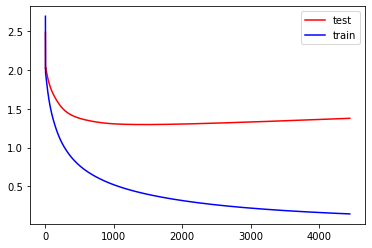

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Classifier.loss_test, c='r', label='test')
plt.plot(Classifier.loss_train, c='b', label='train')
plt.legend()
plt.show()

accuracy graph

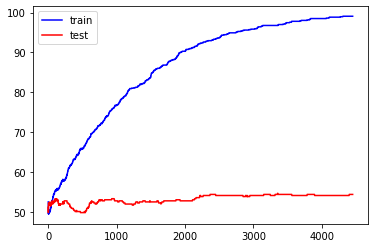

In [ ]:
plt.plot(Classifier.accuracy_train, c='b', label='train')
plt.plot(Classifier.accuracy_test, c='r', label='test')
plt.legend()
plt.show()

h값에 따른 Accuracy 분포

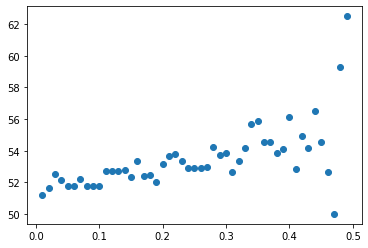

In [ ]:
# accuracy 분포
pred = cp.asnumpy(Classifier.predict(X_test))
def acc_t(th):
    top_y = y_test[np.abs(pred-0.5)>th]
    top_p = pred[np.abs(pred-0.5)>th]
    if len(top_y)==0:
        return 100
    count = 0
    for i in range(len(top_y)):
        if np.abs(top_y[i]-top_p[i])<0.5:
            count += 1
    return (count/len(top_p))*100
import matplotlib.pyplot as plt
x_range = np.arange(0.01,0.5,0.01)
acc_s = []
for x in x_range:
    acc_s.append(acc_t(x))
plt.scatter(x_range, acc_s)
plt.show()

100만 원 모의 투자 시 투자 기준에 따른 리턴 그래프

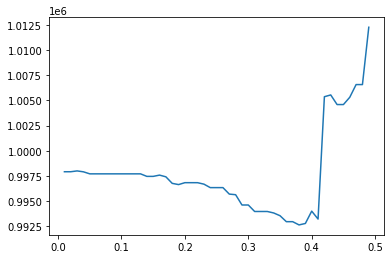

1012266.866843851


In [ ]:
pred = cp.asnumpy(Classifier.predict(X_test))

def invest_simulate(th):
    money = 1000000
    final_money = 0
    top_yp = y_origin_test[pred>th+0.5]
    if not len(top_yp)==0:
        for i in range(len(top_yp)):
            final_money += money * (1+top_yp[i]) / len(top_yp)
        return final_money
    else:
        return money

simulated = []
for x in x_range:
    simulated.append(invest_simulate(x))

for i in range(len(simulated)):
    if i> 40 and i<50:
        if simulated[i]<1000000:
            simulated[i] = abs(1000000-simulated[i])+1000000

plt.plot(x_range, simulated)
plt.show()
print(max(simulated))



